In [6]:
import numpy as np; np.random.seed(1218042)
import seaborn as sb; sb.set()
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook as tqdm 

# Population Model of Competition between ride hailing platforms

Let $f_{R}(t, u)$ and $f_{D}(t, u)$ model the local densities of riders and drivers. Then their growths are determined by:

$$
\frac{\delta}{\delta t}f_{R}(t, u) = R_{R}(t, u)f_{R}(t, u)
$$
$$
\frac{\delta}{\delta t}f_{D}(t, v) = R_{D}(t, v)f_{D}(t, v)
$$

where $R_{R}$ and $R_{D}$ model the net growth rates of rider and drivers respectively:

$$
R_{R}(t, u) := (\kappa_{R} - \mu_{R}\rho_{R}(t)) - \int_{V} \eta_{\theta_{P}}(|u-v|)f_{D}(t, v)dv
$$
$$
R_{D}(t, v) := [\int_{U}\eta_{\theta_{P}}(|u-v|)f_{R}(t, u)du + \kappa_{D}c_{I}(t)] - \frac{\mu_{D}}{1+\mu_{A}c_{A}(t)}\rho_{D}(t)
$$

The implementation is as follows:

#### For riders:

* $\kappa_{R}(V)$ the natural growth rate of rider agents (**barabasi effect on growth**),
* $\mu_{R}$ the reduction in platform attractiveness due to competition for ressources among riders (**waiting time effect**),
* $\rho_{R}(t)$ the total density of riders that are currently seeking rides (**unmet demant**),
* $\eta_{\theta_{P}}$ the price surge in effect with $\theta_{P}$ being the surge coefficient,
* $f_{D}(t, v)$ the density of drivers for platform $v$,
* $u$ indicator of riders for platform $u$,
* $V$ the set of platforms that drivers can join.


#### For drivers:

* $\eta_{\theta_{P}}$ the price surge in effect with $\theta_{P}$ being the surge coefficient,
* $f_{R}(t, u)$ the density of riders for platform $u$,
* $\kappa_{D}(U)$ the natural growth rate of driver agents (**barabasi effect on growth**),
* $c_{I}(t)$ the effect of incentives presented to drivers for them to join platform $v$ (*e.g. financial, advertisment, ...*),
* $\mu_{D}$ the reduction of platform attractiveness for drivers due to competition for ressources amongst drivers (**idle time**),
* $\mu_{A}$ the reduction of platform attractiveness for drivers due to driver attrition,
* $c_{A}(t)$ the effect of external mitigations on driver attrition (*e.g. good employee development programs*),
* $\rho_{D}(t)$ the total density of drivers that are currently seeking rides,
* $v$ indicator of drivers for platform $u$,
* $U$ the set of platforms that riders can join.

## Modelling the growth

To recreate the model, $f_{R,I}$ will be an array of its values where each index reprents its value at time $t$.

At every time step ($\Delta t = 0.1$):

$$f_{R}(t_{k+1}, u) = f_{R}(t_{k}, u) + \Delta t [R^{+}_{R}(t_{k}, u)f_{R}(t_{k}, u) - R^{-}_{R}(t_{k}, u)f_{R}(t_{k+1}, u)]$$
$$f_{D}(t_{k+1}, v) = f_{D}(t_{k}, v) + \Delta t [R^{+}_{D}(t_{k}, v)f_{D}(t_{k}, v) - R^{-}_{D}(t_{k}, v)f_{D}(t_{k+1}, v)]$$

or in explicit terms:

$$f_{R}(t_{k+1}, u) = f_{R}(t_{k}, u) \frac{1+\Delta t R^{+}_{R}(t_{k}, u)}{1+\Delta t R^{-}_{R}(t_{k}, u)} \qquad f_{D}(t_{k+1}, v) = f_{D}(t_{k}, v) \frac{1+\Delta t R^{+}_{D}(t_{k}, v)}{1+\Delta t R^{-}_{D}(t_{k}, v)}$$

We will compute this evolution for various sets of platforms $U$ and $V$.

In [7]:

class StockMarket():

    def __init__(self):
        self.market = {}

    def register(self, platform):
        """ Registers a platform and gives it an authorisation token """
        # Hash the platform to generate unique ID
        token = hash(platform)
        # Store the ID in the market
        self.market[token] = {
            "rider growth": [],
            "driver growth": []
        }
        return token

    def submit_growth(self, growth, token, rider=True):
        """ Registers the platform's most recent growth """
        category = "rider" if rider else "driver"
        self.market[token][f"{category} growth"].append(growth)

    def _most_recent_growth(token):
        if token not in self.market:
            raise ValueError(f"Error: token '{token}' has not been registered at this stock market.")
        return self.market[token]["rider growth"][-1], self.market[token]["driver growth"][-1]

    def request_market_share(self, token):
        """ Returns a barabasi like market share of most recent growth """
        total_r_growths = []
        total_d_growths = []
        for ID in self.market:
            # If the ID matches set this as the numerator
            if ID == token:
                r_growth, d_growth = _most_recent_growth(ID)
            # Fetch and accumulate the growths
            growths = _most_recent_growth(ID)
            total_r_growths.append(growths[0])
            total_d_growths.append(growths[1])
        # Return the ratios
        return r_growth / sum(total_r_growths), d_growth / sum(total_d_growths)


class Platform():

    def __init__(self, stock_market, N=100, t=121, delta_T=0.1,
                        kappa_R=1, kappa_D=1,
                        mu_R=0.5, mu_D=0.5, mu_A=1,
                        c_I=lambda t: 0, c_A=lambda t: 0,
                        f_R=lambda u: np.exp(-np.square(u-0.5)/(0.001))/0.055489413042339474,
                        f_D=lambda v: 1,
                        theta_P=1000):

        # Setup link to stock_market where all growth rates are recorded
        self.stock_market = stock_market
        self.token = self.stock_market.register(self)

        # Set the platform simulation parameters
        self.N = N
        self.t = t
        self.delta_T = delta_T
        self.kappa_R = kappa_R
        self.kappa_D = kappa_D
        self.mu_R = mu_R
        self.mu_D = mu_D
        self.mu_A = mu_A
        self.c_I = c_I
        self.c_A = c_A
        self.f_R = f_R
        self.f_D = f_D
        self.theta_P = theta_P
        
        # General densities of agents (using rectangle integration)
        self.rho_R = lambda f_R: sum(f_R * 1/len(f_R))
        self.rho_D = lambda f_D: sum(f_D * 1/len(f_D))

        # The price surge - to be set to 0 to start with
        # eta_theta_P = lambda u,v: np.exp(-theta_P*np.square(np.abs(u-v)))
        self.eta_theta_P = lambda u,v: 0

        # Generate the initial values
        self.platforms = np.linspace(0, 1, num=self.N)
        self.riders = np.array([[self.f_R(u) for u in self.platforms]])
        self.drivers = np.array([[self.f_D(v) for v in self.platforms]])

    def R_R(self, _f_R, u, _f_D):
        """ Generates the growth of the rider population """
        competition = self.mu_R*self.rho_R(_f_R)
        ride_cost = sum([self.eta_theta_P(u, v) * fv * 1/N for (fv, v) in zip(_f_D, self.platforms)])
        return self.kappa_R - competition - ride_cost
    
    def R_D(self, _f_D, v, _f_R, t):
        """ Generates the growth of the driver population """
        ride_gain = sum([self.eta_theta_P(u, v) * fu * 1/N for (fu, u) in zip(_f_R, self.platforms)])
        attrition = self.mu_D/(1 + self.mu_A*self.c_A(t)) * self.rho_D(_f_D)
        
        return ride_gain + self.kappa_D*self.c_I(t) - attrition

    def split_positive_negative(values):
        """ Splits the input list into a list of its positives and negatives """
        positive, negative = [], []
        for v in values:
            p, n = (0, 0) if v == 0 else ((1, 0) if v > 0 else (0, 1))
            positive.append(v if p else 0)
            negative.append(v if n else 0)
        return np.array(positive), -np.array(negative)

    def simulate_growth(self):
        
        # Apply the growth equation for each time step
        for i in tqdm(1, range(int(t/delta_T))):
            
            # Get f_*[t]
            _f_R = riders[-1]
            _f_D = drivers[-1]

            # Compute the increments
            _R_C = [R_R(_f_R, u, _f_D) for u in platforms]
            _R_I = [R_D(_f_D, v, _f_R, i*delta_T) for v in platforms]
            
            # Get the positive and negative parts of _R_*
            p_R_R, n_R_R = split_positive_negative(_R_C)
            p_R_D, n_R_D = split_positive_negative(_R_I)
            
            # Compute the growths
            delta_R = (1 + delta_T*p_R_R) / (1 + delta_T*n_R_R)
            delta_D = (1 + delta_T*p_R_D) / (1 + delta_T*n_R_D)

            # Register the growths to the stock market
            self.stock_market.submit_growth(delta_R, self.token)
            self.stock_market.submit_growth(delta_D, self.token, rider=False)
            
            # Compute and aggregate f_*[t+1]
            self.riders = np.concatenate((riders, [_f_R * delta_R]))
            self.drivers = np.concatenate((drivers, [_f_D * delta_D]))

    def plot_growth_surface(t=121):
        
        # Create a mesh-grid for printing
        initial_values, time = np.meshgrid(self.platforms, np.linspace(0, 121, num=len(self.riders)))
        fig = plt.figure(figsize=(24, 8))

        #===============
        #  Cancer growth
        #===============
        # set up the axes for the first plot
        ax = fig.add_subplot(1, 2, 1, projection='3d')

        # Plot the surface
        ax.plot_surface(time, initial_values, self.riders)

        # Set labels and title
        ax.set_xlabel('t', size=12)
        ax.set_ylabel('u', size=12)
        ax.set_zlabel('f_R(t, u)', size=12)
        plt.tight_layout()
        plt.title(f'Growth of rider agents', size=15)

        #===============
        # Immune growth
        #===============
        # set up the axes for the second plot
        ax = fig.add_subplot(1, 2, 2, projection='3d')

        # Plot the surface
        ax.plot_surface(time, initial_values, self.drivers)

        # Set labels and title
        ax.set_xlabel('t', size=12)
        ax.set_ylabel('v', size=12)
        ax.set_zlabel('f_D(t, v)', size=12)
        plt.tight_layout()
        plt.title(f'Growth of driver agents', size=15)

        # Show entire figure
        plt.show()

    def plot_growth_cmap(t=121):

        fig = plt.figure(figsize=(12, 8))
        time = np.linspace(0, t, num=len(self.riders))
        # Setup the tick marks (for time and initial values)
        xticks = [i if i in [0, 0.5, 1] else '' for i in self.platforms]
        marks = [0, 200, 400, 600, 800, 1000, 1200]
        yticks = [int(t) if i in marks else '' for i,t in enumerate(time)][::-1]

        #===============
        #  Cancer growth
        #===============
        # set up the axes for the first plot
        ax = fig.add_subplot(1, 3, 1)

        # Plot the heatmap
        ax = sb.heatmap(self.riders[::-1], robust=True, xticklabels=xticks, yticklabels=yticks,
                        cmap='hot', vmin=0, vmax=25)

        # Set labels and title
        ax.set_xlabel('u', size=12)
        ax.set_ylabel('t', size=12)
        plt.tight_layout()
        plt.title(f'f_R(t, u)', size=15)

        #===============
        # Immune growth
        #===============
        # set up the axes for the second plot
        ax = fig.add_subplot(1, 3, 2)

        # Plot the heatmap
        ax = sb.heatmap(self.drivers[::-1], robust=True, xticklabels=xticks, yticklabels=yticks,
                        cmap='hot', vmin=0, vmax=25)

        # Set labels and title
        ax.set_xlabel('v', size=12)
        ax.set_ylabel('t', size=12)
        plt.tight_layout()
        plt.title(f'f_D(t, v)', size=15)
        
        #===============
        # Densities
        #===============
        # set up the axes for the second plot
        ax = fig.add_subplot(1, 3, 3)

        # Plot the heatmap
        plt.plot(time, self.riders.sum(axis=1)/len(self.riders[0]), color='black', label="Rider agents")
        plt.plot(time, self.drivers.sum(axis=1)/len(self.drivers[0]), color='black', linestyle='--', label="Driver agents")

        # Set labels and title
        ax.set_xlabel('t', size=12)
        ax.set_xticks(list(range(0, t, 20)) if t==121 else time)
        ax.set_ylim(0, 2)
        ax.set_ylabel('')
        ax.set_yticks([0, 1, 2])
        plt.legend()
        plt.tight_layout()
        plt.title(f'ρ_R(t) and ρ_D(t)', size=15)

        # Show entire figure
        plt.show()

### -

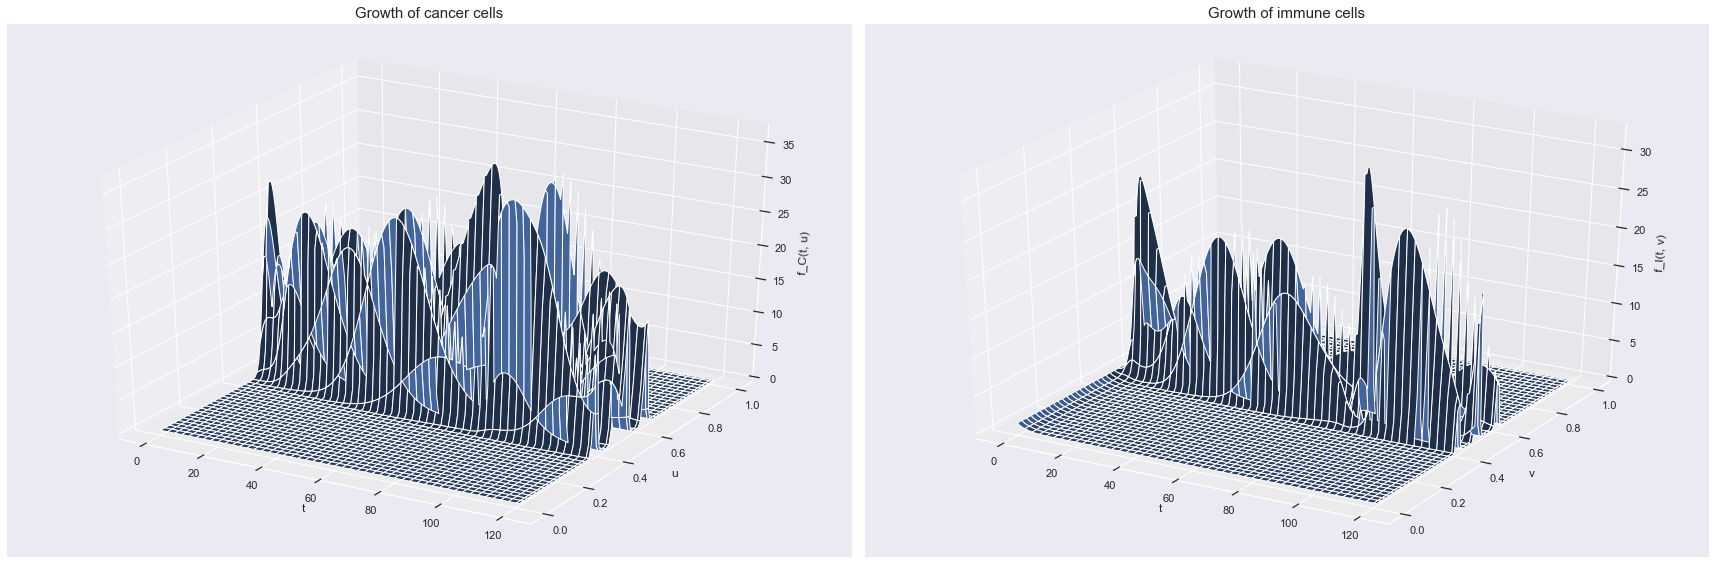

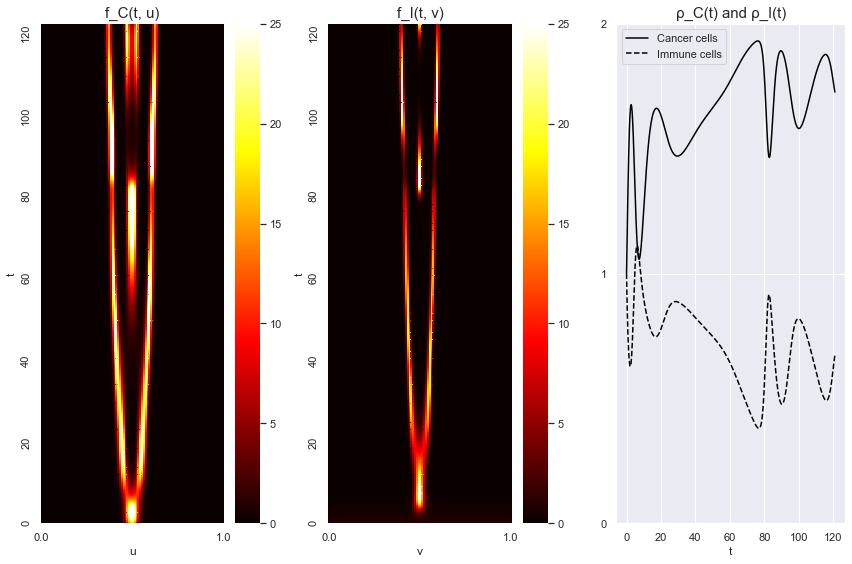

In [8]:
cancer, immune, initial_values = simulate_growth(N=100)
plot_growth_surface(cancer, immune, initial_values)
plot_growth_cmap(cancer, immune, initial_values)